In [2]:
import sys
from sklearn import tree
import os
import analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import ticker

input_file="data/20230721/2023_07_21_all"
output_dir="data/20230817-aly"


apps = ['memcached', 'redis', 'nginx', 'kafka', 'hibench', 'elasticsearch', 'keydb', 'clickhouse']
picYlabel = {
    'vm_cpu_time_sys': 'Cores Used',
    'vm_cpu_time_user': 'Cores Used',
    'vm_cpu_vcpu_time': 'Cores Used',
    'vm_cpu_context_switch': 'Switch Count',
    'vm_cpu_cpi': 'Cycle Per Second',
    'vm_cpu_ips': 'Instructions Per Second',
    
    'vm_cache_mkpi': 'Misses Per Thousand Instructions',
    'vm_mem_usage': 'Memory Usage',
    
    'vm_network_io_bytes_receive': 'Bytes Per Second',
    'vm_network_io_bytes_transmit': 'Bytes Per Second',
    'vm_network_io_packets_receive': 'Packets Per Second',
    'vm_network_io_packets_transmit': 'Packets Per Second',
    
    'vm_block_io_bytes_read': 'Bytes Per Second',
    'vm_block_io_bytes_write': 'Bytes Per Second',
    'vm_block_io_requests_read': 'Requests Per Second',
    'vm_block_io_requests_write': 'Requests Per Second',
}
net_io_metric = 'vm_network_io_packets_receive'
passDevPackets = ['vm_cpu_cpi','vm_cache_mkpi','vm_mem_usage','vm_network_io_bytes_receive']

# apps_remap={"memcached": "k-v store", "keydb": "k-v store", "redis": "k-v store",}
apps_remap = {}

df  = analysis.read_all_in_one_data(f"{input_file}.csv", f"{input_file}.json", apps_remap)

In [3]:
# 每个应用，所哟运行次数合并
dfs1 = df.copy()

grouped = dfs1.groupby(['app_remap','app'])

for (ar,app), group in grouped: 
    data = group.drop(columns=['data_count','app_remap','app']) 
    data = data.sort_values(by='Time')
    data['Time'] = (data['Time'] - data['Time'].min() ) * 100 / (data['Time'].max() - data['Time'].min()) / 100

    for column in data.columns[1:]:
        if "vm" not in column:
            continue
        maxV = dfs1[column].max()*1.1
        bins = 20
        dir = f'{output_dir}/pure/{column}'
        if not os.path.exists(dir):
            os.makedirs(dir)
        lb = 'Value' if column not in picYlabel else picYlabel[column]
        analysis.jobs_prefer_resource(data,column,'Time',maxV,f'{dir}/{app}_total.png',bins,lb)

In [2]:
# 每个应用，每次运行
dfs1 = df.copy()

grouped = dfs1.groupby(['data_count','app_remap','app'])

for (dc,ar,app), group in grouped: 
    data = group.drop(columns=['data_count','app_remap','app']) 
    data['Time'] = (data['Time'] - data['Time'].min() ) * 100 / (data['Time'].max() - data['Time'].min()) / 100

    for column in data.columns[1:]:
        if "vm" not in column:
            continue
        maxV = dfs1[column].max()*1.1
        bins = 20
        dir = f'{output_dir}/pure/{column}'
        if not os.path.exists(dir):
            os.makedirs(dir)
        lb = 'Value' if column not in picYlabel else picYlabel[column]
        analysis.jobs_prefer_resource(data,column,'Time',maxV,f'{dir}/{app}_{dc}.png',bins,lb)

In [4]:
# 除以net.packets
dfs1 = df.copy()

mix = dfs1[net_io_metric].max()*0.001
for column in dfs1.columns[1:-3]:
    if column not in passDevPackets:
        dfs1[column] = dfs1[column]  / ( dfs1[net_io_metric] +  mix)

grouped = dfs1.groupby(['app_remap','app'])

for (ar,app), group in grouped: 
    data = group.drop(columns=['data_count','app_remap','app']) 
    data = data.sort_values(by='Time')
    data['Time'] = (data['Time'] - data['Time'].min() ) * 100 / (data['Time'].max() - data['Time'].min()) / 100

    for column in data.columns[1:]:
        if "vm" not in column:
            continue
        maxV = dfs1[column].max()*1.1
        bins = 20
        dir = f'{output_dir}/dev_network_packets/{column}'
        if not os.path.exists(dir):
            os.makedirs(dir)
        lb = 'Value' if column not in picYlabel else picYlabel[column]
        analysis.jobs_prefer_resource(data,column,'Time',maxV,f'{dir}/{app}_total.png',bins,lb)

In [3]:
# 制作训练数据
dfs1 = df.copy()

mix = dfs1[net_io_metric].max()*0.001
for column in dfs1.columns[1:-3]:
    if column not in passDevPackets:
        dfs1[column] = dfs1[column]  / ( dfs1[net_io_metric] +  mix)

grouped = dfs1.groupby(['data_count','app_remap','app'])

X = []
Label = {}
for (dc,ar,app), group in grouped: 
    data = group.drop(columns=['data_count','app_remap','app']) 
    data = data.sort_values(by='Time')
    data['Time'] = (data['Time'] - data['Time'].min() ) * 100 / (data['Time'].max() - data['Time'].min()) / 100

    cols = []
    for column in data.columns[1:]:
        if "vm" not in column:
            continue
        maxV = dfs1[column].max()*1.1
        buckets = 20
        bins = np.linspace(0, maxV, 10)        
        ht = pd.cut(data[column], bins=bins,labels=False).value_counts().reindex(range(buckets), fill_value=0)
        if ht.sum() != 0:
            ht = ht / ht.sum()
        cols.append(np.array(ht))
    row = np.concatenate(cols)
    X.append(row)
    Label[dc] = app
X = np.vstack(X)

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

random_state = 160

common_params = {
    "n_init": "auto",
    "random_state": random_state,
}

k_means = KMeans(**common_params)
k_means.fit(analysis.normalize(X))

for i, label in enumerate(k_means.labels_):
    print(f"app: {Label[i]} label: {label}")

app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: redis label: 4
app: redis label: 5
app: redis label: 5
app: redis label: 0
app: redis label: 5
app: redis label: 5
app: redis label: 5
app: nginx label: 2
app: nginx label: 2
app: nginx label: 2
app: nginx label: 2
app: nginx label: 2
app: nginx label: 2
app: nginx label: 2
app: kafka label: 1
app: kafka label: 1
app: kafka label: 1
app: kafka label: 1
app: kafka label: 1
app: kafka label: 1
app: kafka label: 1
app: hibench label: 4
app: hibench label: 4
app: hibench label: 4
app: hibench label: 4
app: hibench label: 4
app: hibench label: 4
app: hibench label: 4
app: elasticsearch label: 6
app: elasticsearch label: 6
app: elasticsearch label: 6
app: elasticsearch label: 6
app: elasticsearch label: 6
app: elasticsearch label: 6
app: elasticsearch label: 6
app: keydb label: 0
app: keydb label: 0
app: keydb label: 0
ap

In [1]:
from sklearn.feature_selection import mutual_info_classif

information_gains = mutual_info_classif(X1, Y1)

# # 输出每个属性的信息增益
for idx, ig in enumerate(information_gains):
    print(f"Feature {feature_names[idx]}: {ig:.4f}")

NameError: name 'X1' is not defined

accuracy: 0.5882352941176471, recall_micro: 0.5882352941176471, f1_micro: 0.5882352941176471


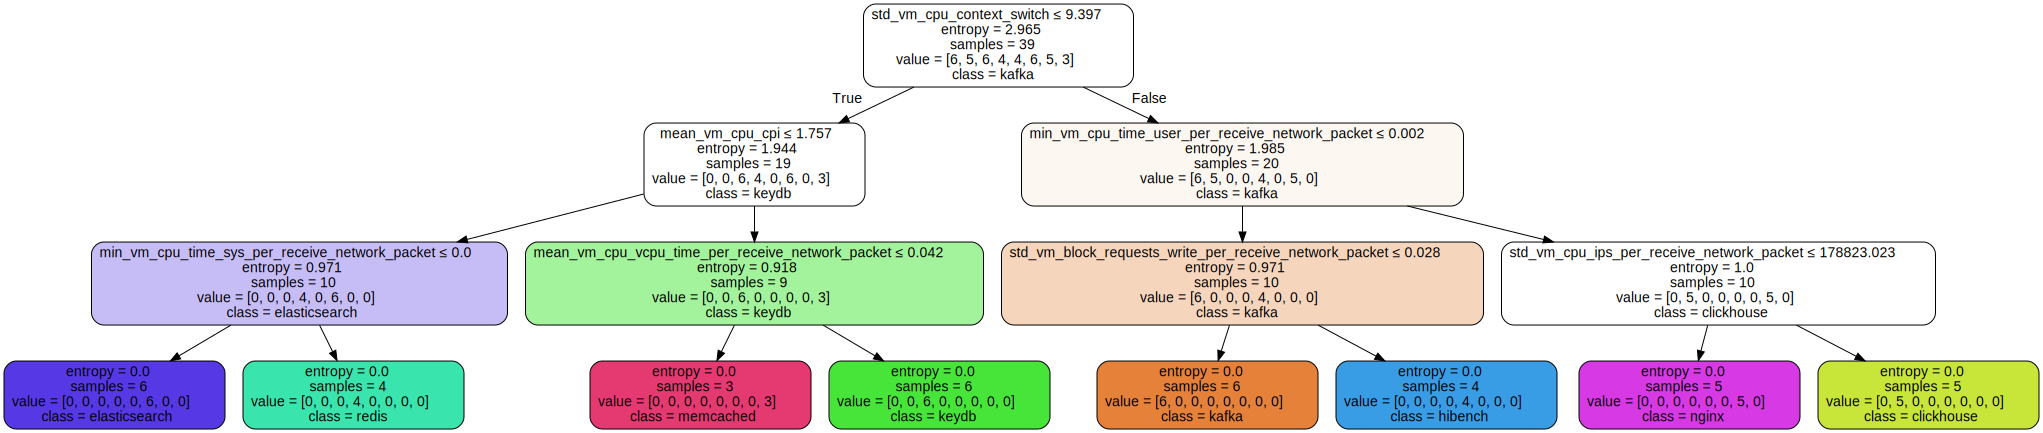

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

cv = 3
clf = tree.DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [1, 2,3,4],
              'min_samples_split': [2],
              'min_samples_leaf': [1],
             'max_features': [0.90]}

# scores = cross_val_score(clf, X, Y, cv=cv, scoring="f1_macro")
# for i in range(0, 32):
grid_search = GridSearchCV(clf, parameters, cv=cv, scoring='f1_macro')
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_

common.model_score(best_model, x_test, y_test)
common.save_dt_to_png(f"best_tree", best_model, feature_names, class_names)

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

random_state = 160

common_params = {
    "n_init": "auto",
    "random_state": random_state,
}

k_means = KMeans(**common_params)
k_means.fit(common.normalize(X))

for i, label in enumerate(k_means.labels_):
    print(f"app: {apps[Y[i][0]]} label: {label}")

app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: memcached label: 0
app: redis label: 0
app: redis label: 0
app: redis label: 0
app: redis label: 0
app: redis label: 0
app: redis label: 0
app: redis label: 0
app: nginx label: 6
app: nginx label: 6
app: nginx label: 6
app: nginx label: 6
app: nginx label: 6
app: nginx label: 6
app: nginx label: 6
app: kafka label: 1
app: kafka label: 1
app: kafka label: 4
app: kafka label: 1
app: kafka label: 4
app: kafka label: 1
app: kafka label: 1
app: hibench label: 6
app: hibench label: 6
app: hibench label: 6
app: hibench label: 6
app: hibench label: 6
app: hibench label: 6
app: hibench label: 6
app: elasticsearch label: 4
app: elasticsearch label: 4
app: elasticsearch label: 4
app: elasticsearch label: 4
app: elasticsearch label: 4
app: elasticsearch label: 4
app: elasticsearch label: 4
app: keydb label: 6
app: keydb label: 6
app: keydb label: 6
ap